# M8: Classification via KNN & SVM
# DAV 6150

- Group Members: Qing Dou, Ruoyu Chen, Zhengnan Li
- Repository: https://github.com/jc000222/Data_Science_DAV6150/tree/main/M8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import auc
import warnings
warnings.filterwarnings('ignore')

# 1. Introduction
In this project, we’ve been tasked by a large insurance company with the development of a model that can predict whether or not a given existing customer is likely to purchase an additional insurance product from the company. The insurance company plans to use the output of such a model in an attempt to improve its customer retention and sales practices. Our task for this Assignment is to construct and compare/contrast a series of K-Nearest Neighbor and Support Vector Machine models that predict whether or not a given insurance company customer is likely to be to purchase an additional insurance product.

### 1.1 Approach:
- [Introduction](#1-introduction): Import the data set and introduce data variables.  
- [EDA](#2-eda): Explore the raw dataset and do analysis based on domain knowledge.  
- [Data Preparation](#3-Data-Preparation): Perform data cleaning, imputation and transformation.  
- [Prepped Data Overview](#4-Prepped-Data-Overview): Re-run the EDA to ensure the data is well prepared for subsequent modeling.  
- [Regression Modeling](#5-Regression-Modeling): Perform two Poisson, two different negative binomial, two multiple linear regression, two KNN, two SVM models and analyse the metrics of the model.  
- [Select Models](#6-Select-Models): Explain how we selected the model selection criteria.  
- [Conclusion](#7-Conclusion)

### 1.2 Data Introduction
The data set is comprised of more than 14,000 observations of 1 response/dependent variable (which indicates whether or not the new insurance product was purchased) and 14 explanatory/independent variables.  
The data set we will be using is sourced from a Kaggle contribution: https://www.kaggle.com/rluyck/insurance-company?select=Customer_data.csv  
Read the data from our github repository. The dataframe is shown below.

In [2]:
customer_raw = pd.read_csv("https://raw.githubusercontent.com/jc000222/Data_Science_DAV6150/main/M7/M7_Data.csv")
customer_raw.head()


,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3


# 2. Exploratory Data Analysis
In this part, we will explore the raw dataset and analyze the missing and invalid values, make histograms and other graphs to determine how to clean the data to improve its usability.  
First start with the matrix of the dataframe. The dataframe has 14016 rows of observations and 15 attributes. We will dive deeper into the dataframe by looking at different columns.

In [3]:
customer_raw.shape

(14016, 15)

Before starting, we define the functions to be used for EDA.

In [4]:
sns.set(style="whitegrid")
def hist(attributes):
    
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.histplot(data=customer_raw[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 5))
        for i in range(len(attributes)):
            sns.histplot(ax=axes[i], data=customer_raw[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
    plt.show()
def box(attributes):
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.boxplot(data=customer_raw[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 5))
        for i in range(len(attributes)):
            sns.boxplot(ax=axes[i], data=customer_raw[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
    plt.show()
def bar(attributes):
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.countplot(x=customer_raw[attributes[0]], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 5))
        for i in range(len(attributes)):
            sns.countplot(ax=axes[i], x=customer_raw[attributes[i]])
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
    plt.show() 
def scatter(attributes):
    if len(attributes) == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        sns.scatterplot(x=customer_raw[attributes[0]],y=customer_raw["TARGET"], ax=axes)
        axes.set_xlabel(attributes[0])
        axes.set_ylabel('shares')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(attributes), figsize=(len(attributes)*4, 5))
        for i in range(len(attributes)):
            sns.scatterplot(ax=axes[i], x=customer_raw[attributes[i]],y=customer_raw["TARGET"],alpha=0.1)
            axes[i].set_xlabel(attributes[i])
            axes[i].set_ylabel('')
            axes[0].set_ylabel('shares')
    plt.show()

| Variables   | Definition  | Data type  | Distribution | Correlation | Explanation  |
|------------------------------|-------------------------------------------------|------------|--------------|-------------|-----------------|
| TARGET      | Indicator of buying the new product (0 = no, 1= yes) | Categorical | Biased  |    NA       | This variable is the response variable.                                    |

This coulumn is the response variable and have the value as "Y" and "N" instead of 1 and 0, thus needs transformation.  
From the barplot below we can tell the data is slightly biased, having "N" for 8000 and "Y" for 6000.

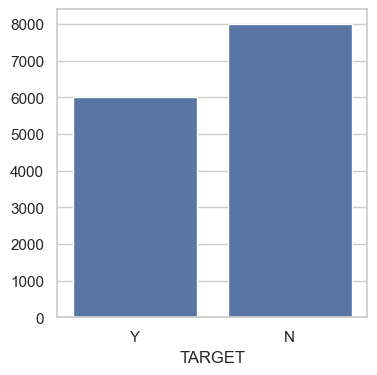

In [5]:
bar(["TARGET"])

| Variables   | Definition  | Data type  | Distribution | Correlation | Explanation  |
|------------------------------|-------------------------------------------------|------------|--------------|-------------|-----------------|
| ID      | Unique customer identifier | NA | NA  |    NA       | This variable is the id of customer.                                    |
| Contract| Type of contract| NA | NA  |    NA       | This variable is contract type of customer.                                   |


ID is the unique identifier for each customer, thus can be dropped.  
Contract only have one unique value 2, thus can be dropped. 

In [6]:
customer_raw["contract"].unique()

array([2], dtype=int64)

### Categorical Variables:

| Variables   | Definition  | Data type  | Correlation | Explanation  |
|------------------------------|-------------------------------------------------|---------------|-------------|-----------------|
| Loyalty      | Loyalty level, from low to high (0 to 3), 99 = unclassified | Ordinal |   NA     | This variable needs to set the unclassified number 99 to null.  |
| City      | Unique code per city |  Non-ordinal   |    NA       | This variable needs to set the unclassified number -999999 to null. This variable has 64 different city code. |
| Type_A      | Type of product A |  Non-ordinal    |    NA       | This variable is the type of product A customer is using. There are 2 types of product A. 0 indicates never bought product A. |
| Type_B      | Type of product B |  Non-ordinal    |    NA       | This variable is the type of product B customer is using. There are 3 types of product B. 0 indicates never bought product B.|
| Prod_A      | Bought Product A (0=no, 1=yes) | Binary |    NA       | This indicates whether bought the product A or not.                            |
| Prod_B      | Bought Product B (0=no, 1=yes) | Binary |    NA       | This indicates whether bought the product A or not.                            |

Variable Prod_A, Prod_B are bound with Type_A, Type_B. When Prod_A is 0, Type_A is also 0; When Prod_A is 1, Type_A can be 3 or 6. This indicates these two variables are highly correlated should be dropped either of them during feature selection.  
For variable "city", "type_A", "type_B","prod_A" and "prod_B" we can try to encode them to dummy variables. But in "type_A" and "type_B" 0 indicates never bought the product and needs to be consider seperately.
In scatter plot, no obvious correlation with the response variable can be observed.

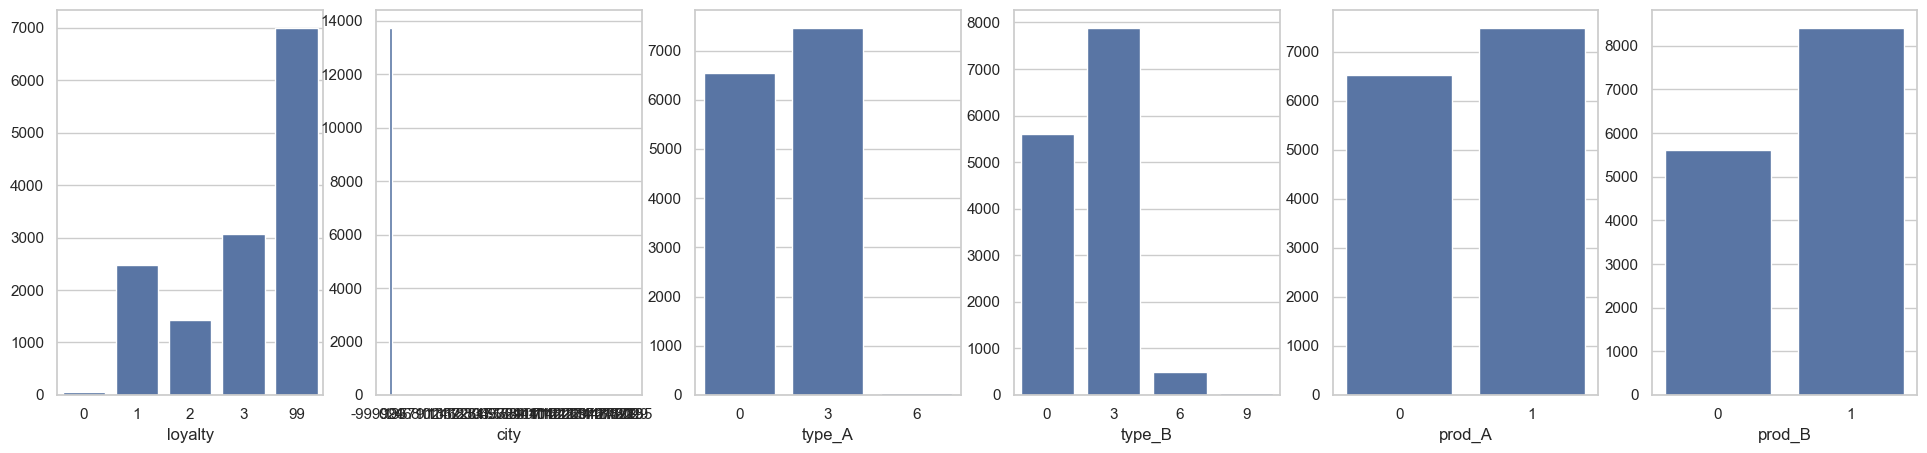

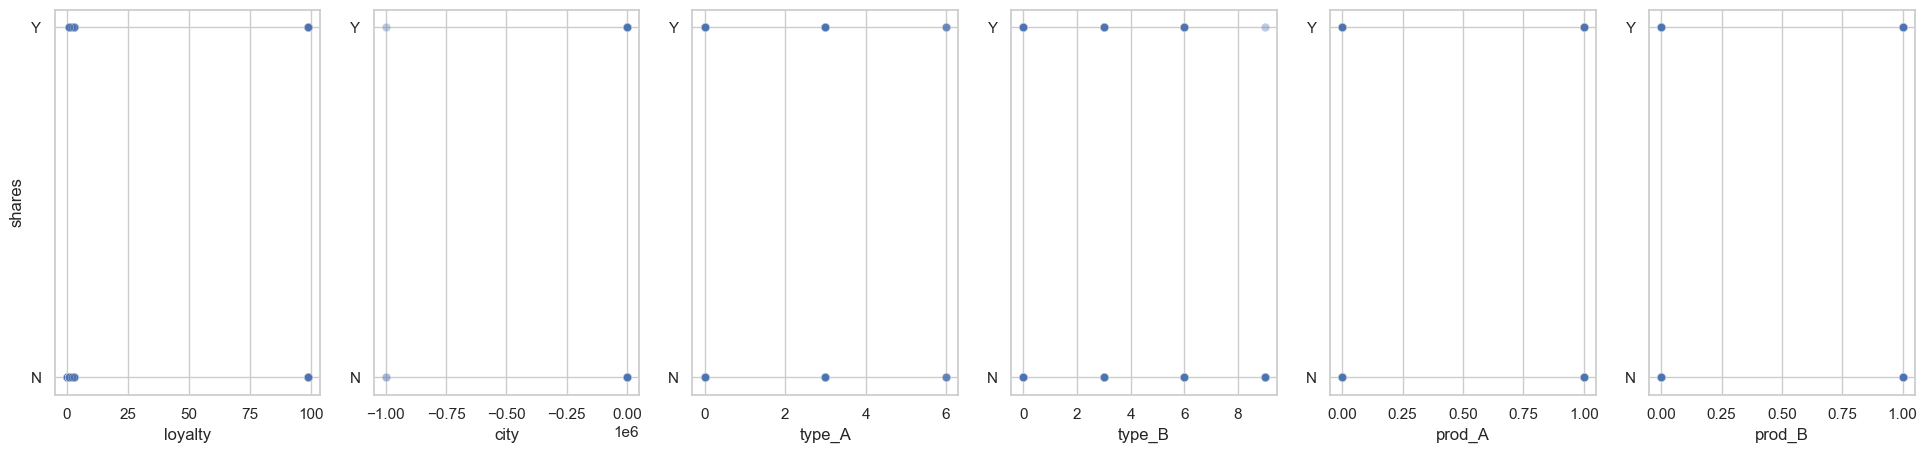

unique codes in city: 64


In [7]:
bar(["loyalty", "city", "type_A", "type_B", "prod_A", "prod_B"])
scatter(["loyalty", "city", "type_A", "type_B", "prod_A", "prod_B"])
print("unique codes in city:",customer_raw[customer_raw["city"] !=-999999]["city"].nunique())


### Numerical  Variables:
| Variables   | Definition  | Distribution | Correlation | Explanation  |
|------------------------------|-------------------------------------------------|---------------|-------------|-----------------|
| Age      | Age in years | Right-Skewed |   NA     | This variable indicates the age of the customer.  |
| Age_p    | Age of partner in years |  Right-Skewed   |    NA       | This variable indicates the age of the partner. |
| LOR      | Length of relationship in years |  Right-Skewed    |    NA       | This variable is the length of relationship in years. |
| LOR_m    | Length of relationship in months |  Right-Skewed    |    NA       | This variable is the length of relationship in months.|
| Turnover_A      | Amount of money spent on Product A | Right-Skewed |    NA       | This indicates the amount of money spent on Product A. Note there are many 0 for the ones who did not buy product A. |
| Turnover_B      | Amount of money spent on Product B | Right-Skewed |    NA       | This indicates the amount of money spent on Product B. Note there are many 0 for the ones who did not buy product B.|

The Age and Age_P is exactly the same, so we can drop one of the variable. Also the LOR and lor_M is very similar, we can drop the LOR.
In scatter plot, no obvious correlation with the response variable can be observed.

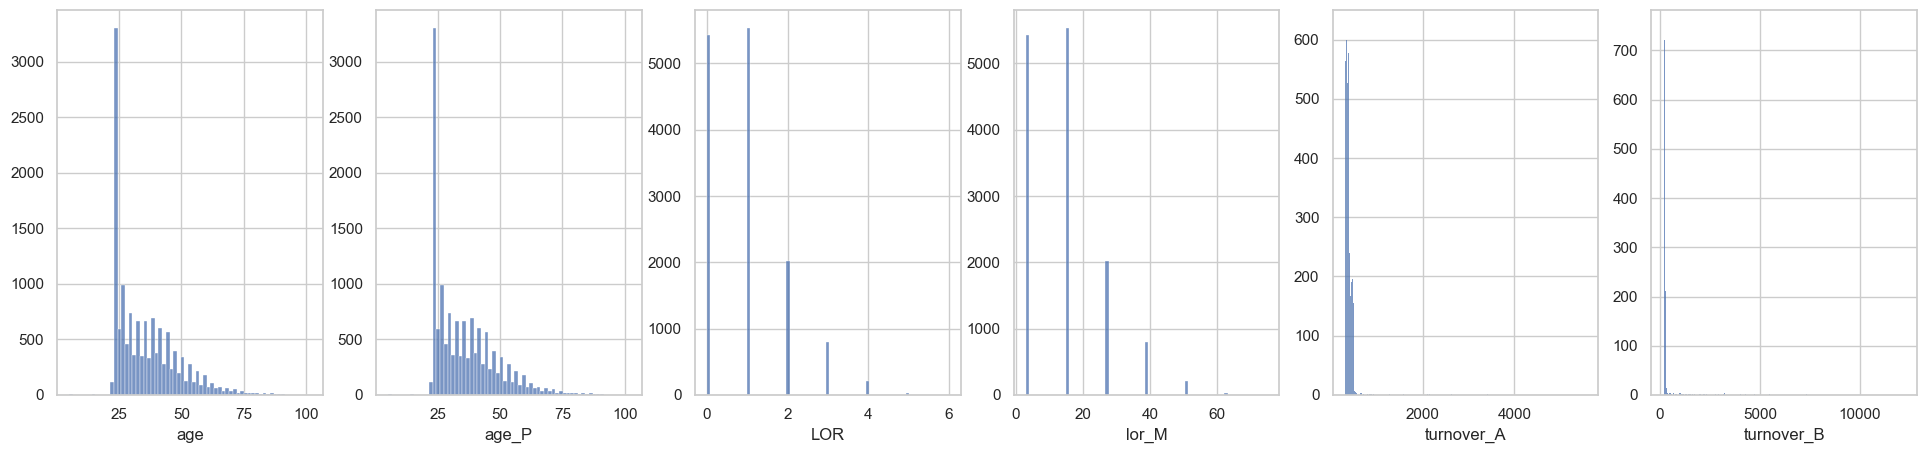

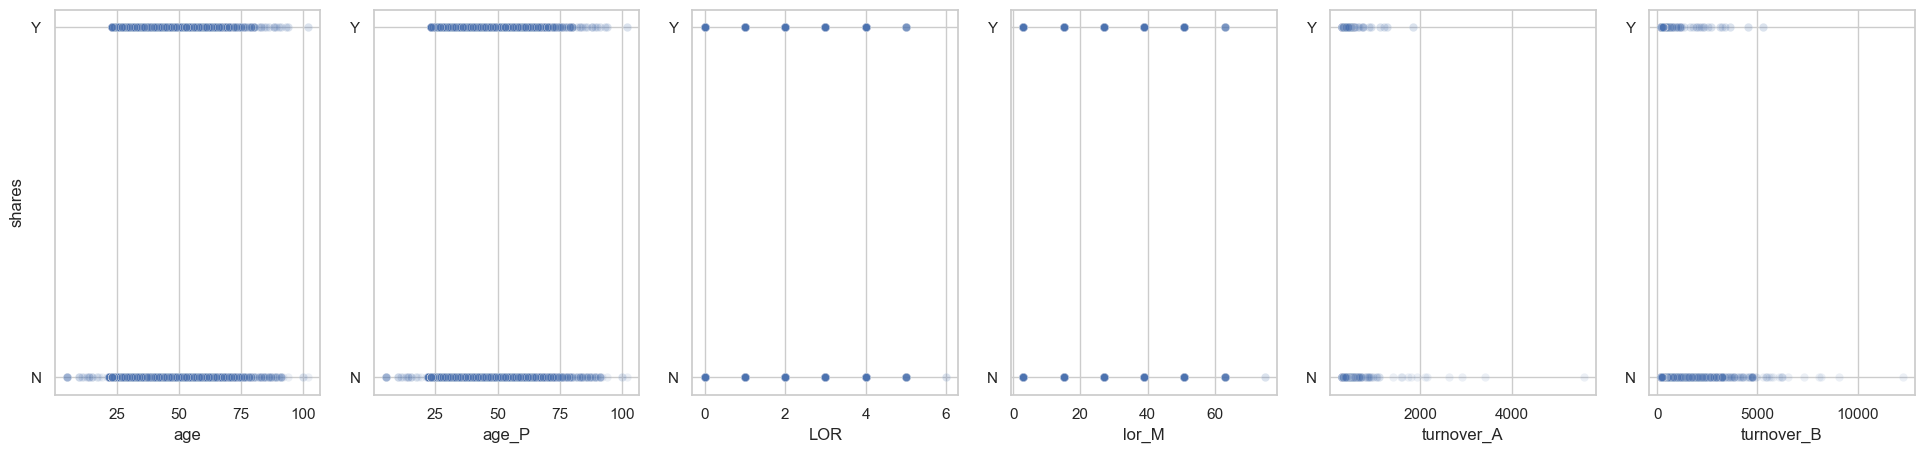

In [8]:
hist(["age", "age_P", "LOR", "lor_M", "turnover_A", "turnover_B"])
scatter(["age", "age_P", "LOR", "lor_M", "turnover_A", "turnover_B"])

## 3. Data Preparation

Describe + show the steps we have taken to address the data integrity +
usability issues we identified in our EDA, including any feature engineering techniques we have
applied to the data set. This section should include any Python code used for Data Preparation.

### 3.1 Data cleaning

There are 3008 rows are duplicated. Drop all the lines that are duplicated.

In [9]:

duplicate_rows = customer_raw.duplicated()
print("duplicate rows:",duplicate_rows.sum())

customer_raw[duplicate_rows]
customer_raw.drop_duplicates(subset=None,keep = 'first',inplace=False)

duplicate rows: 3008


,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11003,N,1,16793,33,2,2,1,3,3,1,302.380331,229.457986,2,33,27
11004,N,99,16794,23,2,0,0,0,0,0,316.268616,228.518505,2,23,3
11005,N,1,16798,23,2,2,1,3,3,1,385.871241,236.665515,2,23,27
11006,N,99,16800,32,2,1,1,3,3,1,317.578868,226.899614,2,32,15


For the indicaters for unclassified, set them to NULL. 

In [10]:
customer_raw['loyalty'].replace(99, np.nan, inplace=True)
customer_raw['city'].replace(-999999, np.nan, inplace=True)

### 3.2 NULL Check
After setting the unclassified values, we can check the null value distribution. In varaible "loyalty", there are too much null values and we can drop the column during feature selection. For the null values in city, we can simply drop the 10 rows.

TARGET           0
ID               0
age              0
LOR              0
prod_A           0
type_A           0
type_B           0
prod_B           0
turnover_A       0
turnover_B       0
contract         0
age_P            0
lor_M            0
city            10
loyalty       6986
dtype: int64

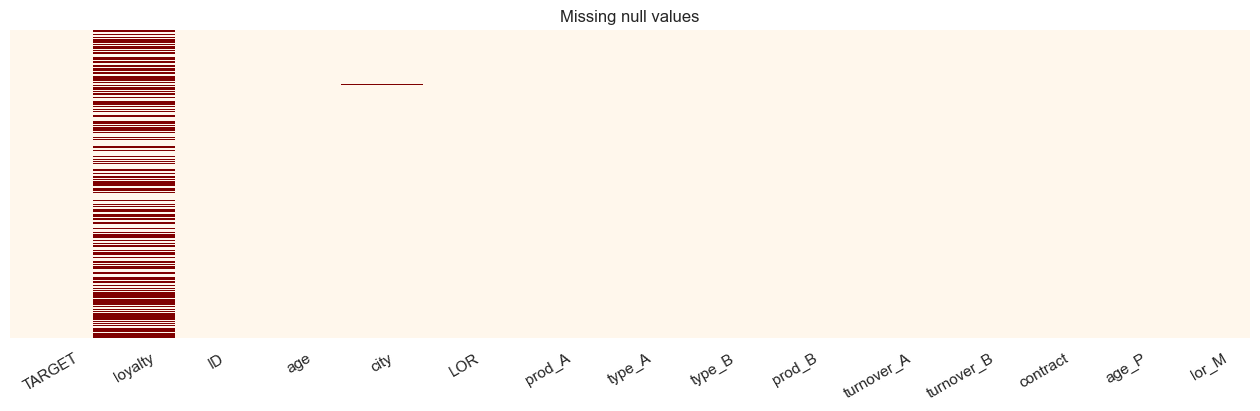

In [11]:
plt.rcParams["figure.figsize"] = (16, 4)
sns.heatmap(customer_raw.isnull(), yticklabels=False, cbar=False, cmap="OrRd")
plt.title("Missing null values")
plt.xticks(rotation=30)
customer_raw.isnull().sum().sort_values()

### 3.3 Duplicated rows check

Let's filter the duplicated rows because duplicate records can mislead data analysis and model training, leading to inaccurate results. By removing these duplicates, we ensure that each observation is unique, thus improving the quality of our data set. 

In [12]:
duplicates = customer_raw.duplicated(keep='first')

print({duplicates.sum()} )

{3008}


We notice that there is a column 'Id' and there are 3008 duplicated rows which may mean data entry errors or repeated collection of information. So, we need to drop these rows.

In [13]:
customer_raw = customer_raw.drop_duplicates()

### 3.4 Column Drop

Through the EDA analysis, we choose to drop contract, age_p, loyalty and ID from the dataframe. Since only 10 null values in city, we can drop the rows. 
When analyzing more than 14,000 rows of data, we found only 300 data where city is not equal to 2. Given the small percentage of these data in the overall dataset, we decided to drop the line where city is not equal to 2. Such processing can help us focus on data where city equals 2, simplifying the analysis process and potentially improving the accuracy and efficiency of the model.

In [14]:
# Delete rows in the 'city' column that contain null values.
customer_cleaned = customer_raw.dropna(subset=["city"])

# Delete rows in the 'city' column that not equal to 2.
df_coustomer = customer_cleaned[customer_cleaned['city'] == 2]

# Remove the column contract, age_p, loyalty and ID from the dataframe
columns_to_drop = ['contract', 'age_P', 'ID','type_A','type_B','loyalty','LOR','city']
df_coustomer = customer_cleaned.drop(columns=columns_to_drop)

### 3.4 Feature Selection

In [15]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#### Variable Processing  
Transfer the catergorical variable to dummy variables and use MinMaxScaler to scale numerical features

__Categorical variable__

First we convert the Response variable ‘target’ to the dummy variable. Then we convert the 'city','loyalty', and merge them with 'prod_A','prod_B' into a new categorical dataframe. We use the SelectKBest function to choose the best 20 categorical features.

In [16]:
# Dummy the Response variable
df_coustomer['TARGET']=pd.get_dummies(df_coustomer['TARGET'], drop_first=True).astype(int)
df_coustomer

,TARGET,age,prod_A,prod_B,turnover_A,turnover_B,lor_M
0,1,66,0,0,333.561114,264.721010,3
1,1,45,1,1,394.735699,284.904978,39
2,1,42,1,1,342.180990,1175.589721,27
3,1,31,0,0,453.757916,242.341754,3
4,1,62,0,0,384.577469,287.008370,3
...,...,...,...,...,...,...,...
11003,0,33,1,1,302.380331,229.457986,27
11004,0,23,0,0,316.268616,228.518505,3
11005,0,23,1,1,385.871241,236.665515,27
11006,0,32,1,1,317.578868,226.899614,15


In [17]:
df_cate=df_coustomer[['prod_A','prod_B']]

__Numerical variable__

First we use MinMaxScaler to scale numerical features to have them in the same range [0, 1] for better model performance.

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Using MinMaxScaler to scale numerical features.
df_num = df_coustomer[['age', 'turnover_A', 'turnover_B','lor_M']]
scaler = MinMaxScaler()

df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns, index=df_num.index)
df_num_scaled

,age,turnover_A,turnover_B,lor_M
0,0.628866,0.006352,0.006034,0.000000
1,0.412371,0.017963,0.007708,0.500000
2,0.381443,0.007988,0.081581,0.333333
3,0.268041,0.029165,0.004178,0.000000
4,0.587629,0.016035,0.007883,0.000000
...,...,...,...,...
11003,0.288660,0.000434,0.003110,0.333333
11004,0.185567,0.003070,0.003032,0.000000
11005,0.185567,0.016280,0.003708,0.333333
11006,0.278351,0.003318,0.002898,0.166667


In [19]:
# Combine feature selected categorical variables and scaled numerical variables
X_final = pd.concat([df_cate, df_num_scaled], axis=1)
y = df_coustomer['TARGET']

# Merge target variables, if needed
df_final = pd.concat([X_final, y], axis=1)
df_final


,prod_A,prod_B,age,turnover_A,turnover_B,lor_M,TARGET
0,0,0,0.628866,0.006352,0.006034,0.000000,1
1,1,1,0.412371,0.017963,0.007708,0.500000,1
2,1,1,0.381443,0.007988,0.081581,0.333333,1
3,0,0,0.268041,0.029165,0.004178,0.000000,1
4,0,0,0.587629,0.016035,0.007883,0.000000,1
...,...,...,...,...,...,...,...
11003,1,1,0.288660,0.000434,0.003110,0.333333,0
11004,0,0,0.185567,0.003070,0.003032,0.000000,0
11005,1,1,0.185567,0.016280,0.003708,0.333333,0
11006,1,1,0.278351,0.003318,0.002898,0.166667,0


#### Feature selection
In order to improve the model accuracy and reduce overfitting， and the variables for model is not too much for RFE to helps in Handling Multicollinearity. Let's use RFE method to do the feature selection.

In [20]:
# Separate features and target variables
X = df_final.drop('TARGET', axis=1)
y = df_final['TARGET']

# Use the train_test_split function to get the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a Logistic Regression model.
# Increase the number of iterations to ensure convergence.
logreg = LogisticRegression(max_iter=1000) 

# Apply RFE to select the 5 most important features.
rfe = RFE(estimator=logreg, n_features_to_select=5) 
rfe = rfe.fit(X_train, y_train.values.ravel()) 

# Gets the column name of the feature selected by RFE
selected_features = X_train.columns[rfe.support_]

# Output the results of RFE.
print("Selected features by RFE:")
print(rfe.support_)
print("Feature ranking (1 indicates selected):")
print(rfe.ranking_)
print("Selected features by RFE (ranking 1):")
print(selected_features)


Selected features by RFE:
[False  True  True  True  True  True]
Feature ranking (1 indicates selected):
[2 1 1 1 1 1]
Selected features by RFE (ranking 1):
Index(['prod_B', 'age', 'turnover_A', 'turnover_B', 'lor_M'], dtype='object')


#### SMOTE 
Based on the results We finally choose ['prod_B', 'age', 'turnover_A', 'turnover_B', 'lor_M'] as our variables for modeling. And we have already seen that the Target is inbalanced. So, we also need SMOTE function to deal with this problems.

In [21]:
# Using SMOTE to deal with the inbalanced situation of TARGET for training data set.
X_train_selected = X_train[selected_features]
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train_selected, y_train)

# Output the data distribution after oversampling
print("Original dataset shape %s" % y.shape)
print("Resampled dataset shape %s" % y_sm.shape)

X_train = X_sm[['prod_B', 'age', 'turnover_A', 'turnover_B', 'lor_M']]
X_test = X_test[['prod_B', 'age', 'turnover_A', 'turnover_B', 'lor_M']]
y_train = y_sm
y_test = y_test

Original dataset shape 11000
Resampled dataset shape 12774


## 4. Prepped Data Review 

The prepped data is for modeling, so the data for plot is from the x_train and y_train. It is obvious that the chart is different especially the distribution of TARGET after SMOTE.

In [22]:
response_variables = pd.DataFrame(y_sm, columns=['TARGET'])
features_variables = X_train
combined_df = pd.concat([features_variables.reset_index(drop=True), response_variables.reset_index(drop=True)], axis=1)

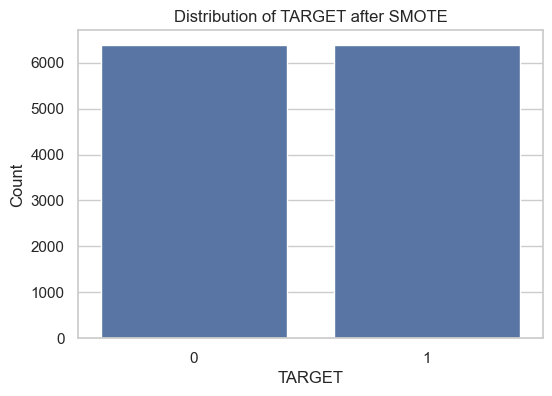

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=response_variables)
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.title('Distribution of TARGET after SMOTE')
plt.show()

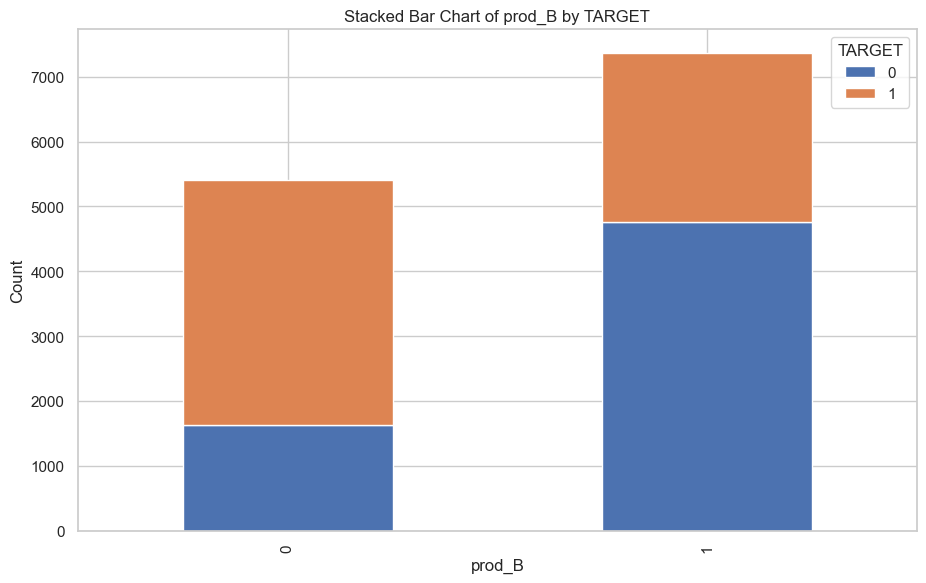

In [24]:
# Compare the response variable with categorcial variables
plt.figure(figsize=(18, 6))

# Loop through each categorical variable
for i, category in enumerate(['prod_B'], start=1):
    plt.subplot(1, 2, i)
    # Count each category
    grouped = combined_df.groupby([category, 'TARGET']).size().unstack(fill_value=0)
    grouped.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Stacked Bar Chart of {category} by TARGET')
    plt.xlabel(category)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

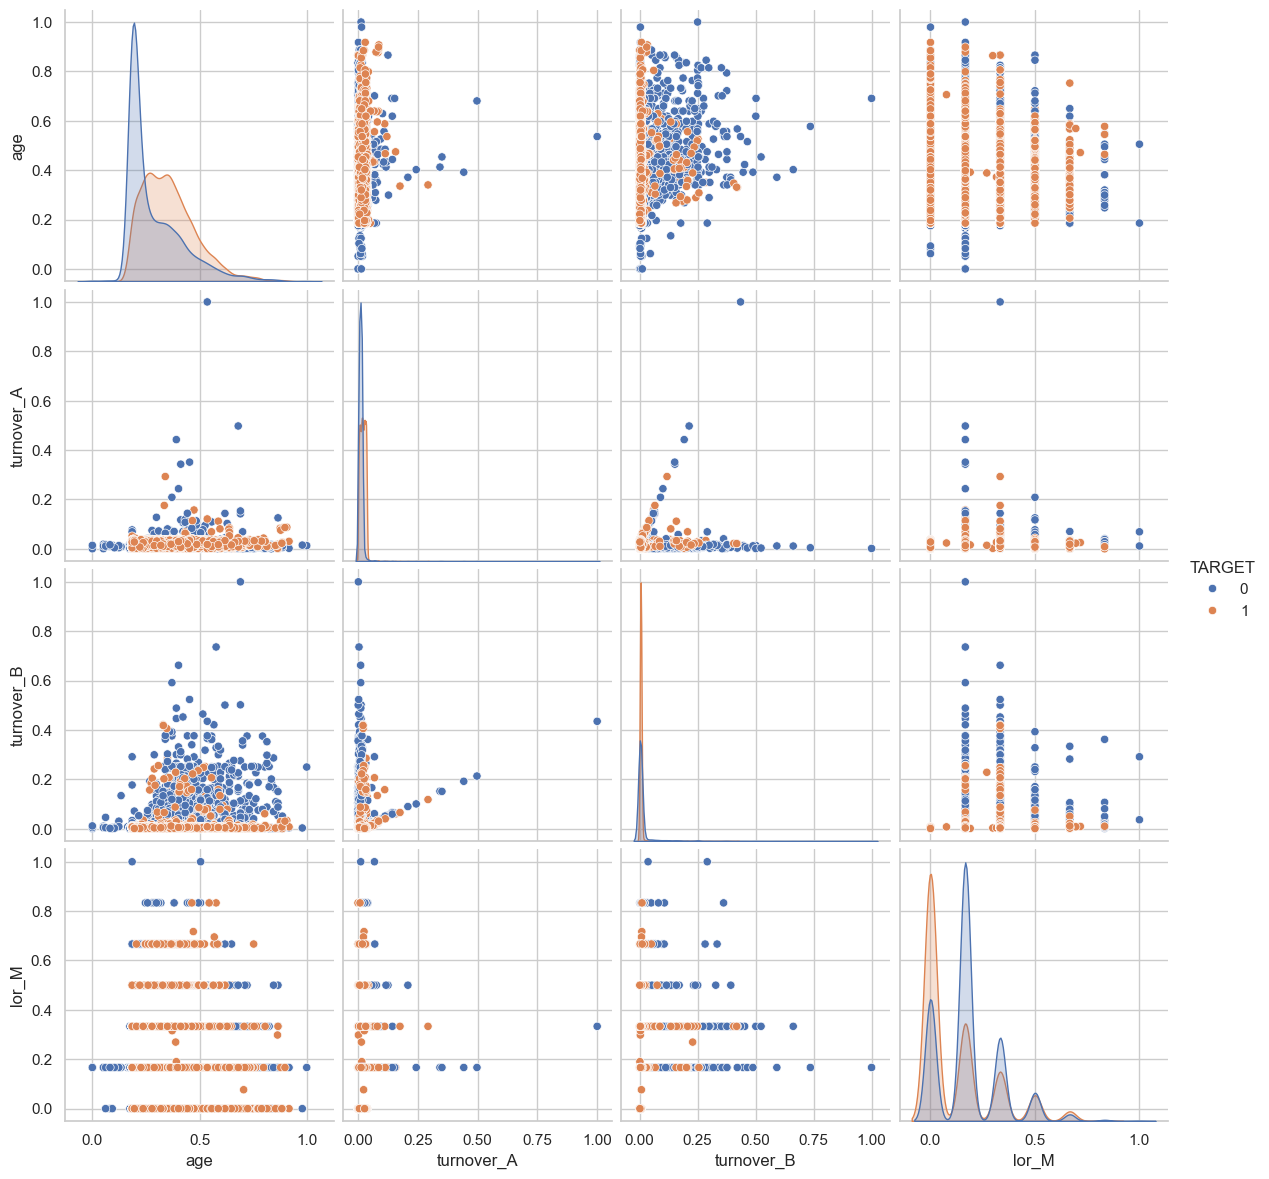

In [25]:
# Compare the response variable with numerical variables
df_num1=combined_df[['age','turnover_A','turnover_B','lor_M','TARGET']]
sns.pairplot(df_num1, hue='TARGET',size=3)
plt.show()

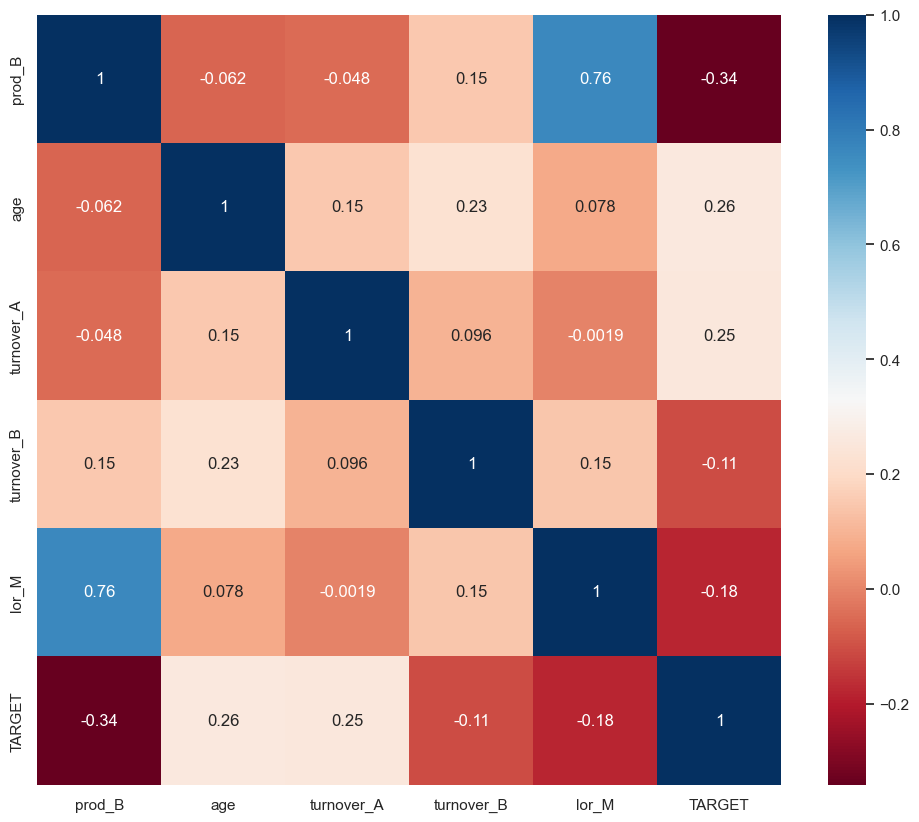

In [26]:
# Use the heatmap to visualize the correlation between each feature
# Finding the correlation bewteen the Features.
plt.figure(figsize=(12,10))
corr = combined_df.corr()

# Plot the heatmap
sns.heatmap(corr, cmap="RdBu",xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.show()

## 5. Model Building

### 5.1 Regression Modeling

In the section, we will use the features which are selected from the eda which used MinMaxScaler to scale numerical features to have them in the same range [0, 1] for better model performance. So, we will try to train our models with different features include categorical variables and numeric variables.Theoretically, we would expect characteristics like age and customer relationship duration to be positively related to the target variable because customers may become more inclined toward certain types of products or services as they age or the customer relationship duration increases.

__Regression Model 1__  
Choose only the numerical variables for model 1.

In [27]:
# Choose numerical variables for model 1
X1_train = X_train[['age','turnover_A','turnover_B','lor_M']]
y1_train = y_train

# Perform logistic regression
regression_model_1 = LogisticRegression()

# Train the model
regression_model_1.fit(X1_train, y1_train)

print(regression_model_1.coef_)

[[ 5.03617545 15.31526931 -8.86958265 -2.51334351]]


__Regression Model 2__  
Adding categorical variables Prod_B for model 2.

In [28]:
# Choose categorical variables for model 2

X2_train = X_train
y2_train = y_train

regression_model_2 = LogisticRegression()

# Train the model
regression_model_2.fit(X2_train, y2_train)

print(regression_model_2.coef_)

[[-1.7609482   4.34689784 14.36172359 -7.51473219  1.48662557]]


### 5.2 KNN Modeling


We will use the cross-validation method to select the best 'K' value for the optimal number of neighbors.
- Using "optimal_k" to determine the optimal number of k for the KNN classifier by iterating over a range of odd values from 1 to 49. For each k value, it trains a KNN model using 5-fold cross-validation on the provided training data (X, y) and computes the mean accuracy score. Then plots these scores to visualize how accuracy changes with different k values and returns the k value that resulted in the highest mean accuracy.

In [29]:
def optimal_k(X, y, metric='accuracy'):
    # Define a range of k values to test
    k_values = range(1, 50, 2)
    mean_scores = []

    # Evaluate each k value
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        scores = cross_val_score(model, X, y, cv=5, scoring=metric)
        mean_scores.append(scores.mean())

    # Find the k value with the highest mean accuracy
    best_k = k_values[mean_scores.index(max(mean_scores))]
    print(f'The best k value is: {best_k}')
    
    # Plotting the k values against their mean accuracy scores
    plt.figure(figsize=(10,6))
    plt.plot(k_values, mean_scores, color='green', linestyle='dotted', marker='*', markersize=12)
    plt.title('K Value vs. Accuracy')
    plt.xlabel('K')
    plt.show()

    return best_k

- Using tr_knn function to train a KNN classifier using the provided k value on the training data and then evaluates its accuracy by performing 10-fold cross-validation. It returns the trained KNN model.
- Using 'evaluate_model' function to train model and evaluate it by using accuracy, recall, ROC AUC, F1 score, and precision.

The best k value is: 1


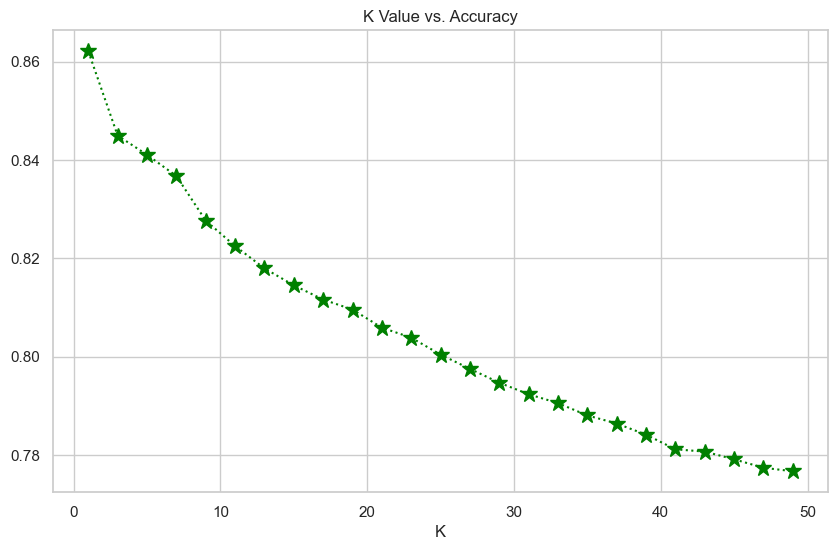

In [30]:
# Train and evaluate KNN model by using the specified k value
def tr_knn(X, y, k, metric='accuracy'):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    accuracy = cross_val_score(knn, X, y, scoring=metric, cv=10).mean()
    print(f"Accuracy of KNN with k={k}: {accuracy}")
    return knn

# Get the best k value
optimal_k_value = optimal_k(X_train, y_train, 'accuracy')

__KNN Model 1__  
We choose the k value as the optimal k value we calculated before.

In [31]:

knn_model_1 = tr_knn(X_train, y_train, optimal_k_value)

Accuracy of KNN with k=1: 0.8619883750427387


__KNN Model 2__  
We choose the k value as 3 as a greater value compared with the optimal k value to experiment with it.

In [32]:
knn_model_2 = tr_knn(X_train, y_train, optimal_k_value + 2)

Accuracy of KNN with k=3: 0.8477410009522025


### 5.3 SVM classifier
In this section we will perform two different SVM models via different transformation methods, with the built in function of SVM.

__SVM Model 1 : Linear SVM__   
Linear SVM is the basic form of SVM that constructs a linear decision boundary to separate classes.  
It is suitable for linearly separable datasets and often used as a baseline model for classification tasks.

In [33]:
X5_train = X_train
y5_train = y_train

svm_classifier_1 = SVC(kernel='linear', random_state=24) 
svm_classifier_1.fit(X5_train, y5_train)
svm_classifier_1.coef_


array([[-1.74692447,  2.75652035, 17.26983821, -6.24656998,  0.87483974]])

__SVM Model 2: Radial Basis Function (RBF) SVM__    
RBF SVM (also known as Gaussian kernel SVM) is a powerful extension of SVM that uses radial basis function kernel to map the data into an infinite-dimensional space.  
It can model complex non-linear decision boundaries and is effective for datasets with complex relationships.

In [34]:
X6_train = X_train
y6_train = y_train

svm_classifier_2 = SVC(kernel='rbf') 
svm_classifier_2.fit(X5_train, y5_train)

SVC()

## 6. Select models
When selecting the best model, we considered several key factors, including the model's precision, recall, f1-score, and support. These metrics give a comprehensive picture of the model's performance, taking into account not only the model's ability to predict positive classes (accuracy and recall), but also the overall accuracy of the model's predicted results (F1 scores). By comparing these metrics across different models, we are able to get a more complete picture of each model's strengths and weaknesses, and select the model that performs best in our particular application scenario.

In [47]:
weighted_avg_metrics = []

model1_test = X_test[['age','turnover_A','turnover_B','lor_M']]
predictions_1 = regression_model_1.predict(model1_test)
report_1 = classification_report(y_test, predictions_1, output_dict=True)
weighted_avg_metrics.append({'model': 'regression_model_1', **report_1['weighted avg']})

predictions_2 = regression_model_2.predict(X_test)
report_2 = classification_report(y_test, predictions_2, output_dict=True)
weighted_avg_metrics.append({'model': 'regression_model_2', **report_2['weighted avg']})

predictions_3 = knn_model_1.predict(X_test)
report_3 = classification_report(y_test, predictions_3, output_dict=True)
weighted_avg_metrics.append({'model': 'knn_model_1', **report_3['weighted avg']})

predictions_4 = knn_model_2.predict(X_test)
report_4 = classification_report(y_test, predictions_4, output_dict=True)
weighted_avg_metrics.append({'model': 'knn_model_2', **report_4['weighted avg']})

predictions_5 = svm_classifier_1.predict(X_test)
report_5 = classification_report(y_test, predictions_5, output_dict=True)
weighted_avg_metrics.append({'model': 'svm_classifier_1', **report_5['weighted avg']})

predictions_6 = svm_classifier_2.predict(X_test)
report_6 = classification_report(y_test, predictions_6, output_dict=True)
weighted_avg_metrics.append({'model': 'svm_classifier_2', **report_6['weighted avg']})

final_report = pd.DataFrame(weighted_avg_metrics)


final_report[['model',	'precision',	'recall',	'f1-score']]


,model,precision,recall,f1-score
0,regression_model_1,0.773974,0.745909,0.755076
1,regression_model_2,0.745015,0.669545,0.687577
2,knn_model_1,0.813502,0.802727,0.806764
3,knn_model_2,0.810952,0.794545,0.800147
4,svm_classifier_1,0.741678,0.690000,0.704922
5,svm_classifier_2,0.797029,0.765455,0.774718


When considering multiple models, knn_model1 has the most outstanding performance and the highest accuracy. It aslo has the highest AUC. High accuracy and high recall results in high F1 scores. Considering that we are more focused on whether the customer buys the product, the cross-validation results of knn_model3 are better than other models. Compared with logistic regression model and svm model, KNN_Model3 has better performance on many performance indicators. Therefore, after evaluating nine models, we chose KNN_Model3 as the preferred model and will further test set validation to confirm the performance of its training set.

Next, Let's see the AUC and ROC to analyze the performance of the model 3.

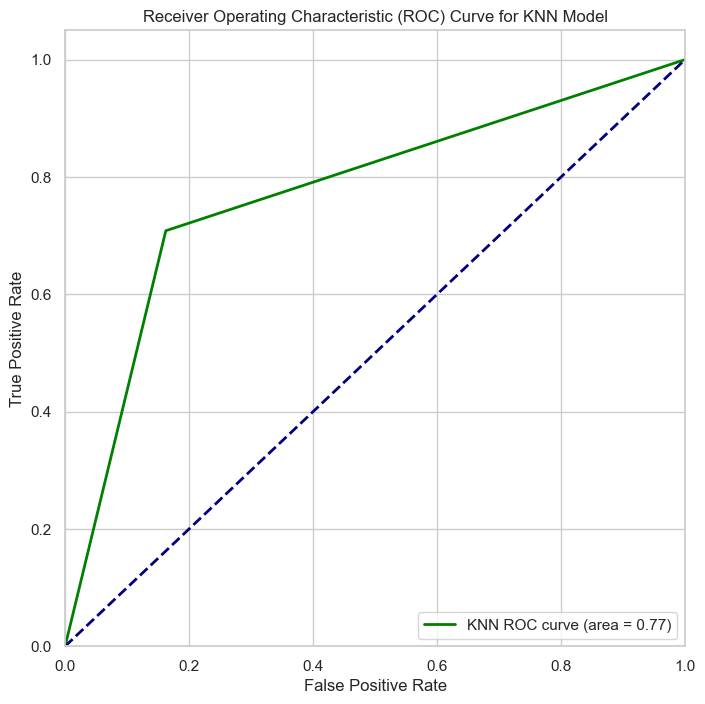

KNN Model AUC Score: 0.7729243161505681
Classification Report for KNN Model:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1607
           1       0.62      0.71      0.66       593

    accuracy                           0.80      2200
   macro avg       0.75      0.77      0.76      2200
weighted avg       0.81      0.80      0.81      2200



In [46]:

y_score_knn = knn_model_1.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC curve for KNN Model
plt.figure(figsize=(8, 8))
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN Model')
plt.legend(loc='lower right')
plt.show()

# Print AUC score for KNN Model
print("KNN Model AUC Score:", roc_auc_knn)

# Use the trained KNN model to predict the outcomes for the test set
predictions_3 = knn_model_1.predict(X_test)

# Generate and print a classification report, including the F1 score, among other metrics
print("Classification Report for KNN Model:")
print(classification_report(y_test, predictions_3))


- AUC score: The AUC score is 0.7729, and the closer this value is to 1, the better the model is at distinguishing between positive and negative categories.
- ROC curve: The curvature of the curve in the upper right corner is good, which indicates that the model can achieve a high true positive rate with a low false positive rate.

However, the ROC curve of SVM_classification_1 shows a better shape and a higher AUC value of 0.84.
- AUC score: The AUC score is 0.841707, and the closer this value is to 1, the better the model is at distinguishing between positive and negative categories.
- ROC curve: The curvature of the curve in the upper right corner is good, which indicates that the model can achieve a high true positive rate with a low false positive rate.

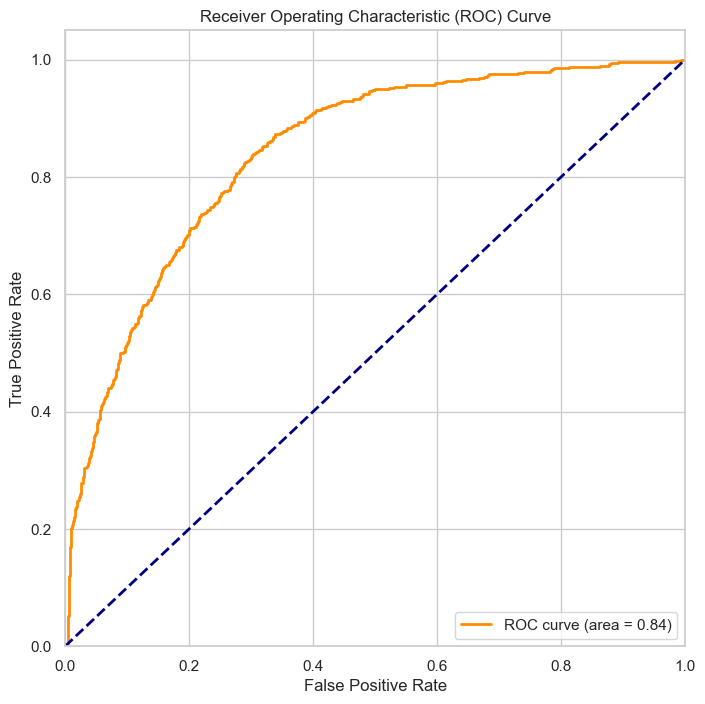

AUC Score: 0.8417074959782822


In [48]:
import matplotlib.pyplot as plt

y_score = svm_classifier_2.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC Score:", roc_auc)


## 7. Conclusions
Our project on SNN and SVM models for an insurance company successfully highlighted key customer characteristics predictive of additional product purchases. Through detailed data analysis and model evaluation, including feature selection and handling imbalanced data with SMOTE, we identified the most effective model. This model, leveraging both numerical and categorical data, offered insights into customer behavior, thereby aiding the company's sales strategies and customer retention efforts. 

## Reference
Our methodology and analytical strategies were informed by a blend of academic literature and practical guides, including foundational principles of logistic regression analysis and model evaluation techniques as outlined on platforms such as scikit-learn.org.
- https://www.cnblogs.com/ljhdo/p/10600702.html
- https://scikit-learn.org/stable/modules/model_evaluation.html